<a href="https://colab.research.google.com/github/ErnyBSB/dadosTabularesJob/blob/main/ProjetoEntregaFinalGrupo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto da Disciplina de Deep Learning para dados tabulares e Séries Temporais

alunos:
1. Ernesto Carlos Bodê
2. João Victor Nunes
3. Gabriel Souza Marques

In [ ]:
#@title CONEXÃO AO GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title BIBLIOTECAS BÁSICAS

import pandas as pd
import requests
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
#@title Carregamento de dados >> eletric production (aluno 1)
"""
link original do DataSet >> https://www.kaggle.com/datasets/shenba/time-series-datasets?resource=download
"""

try:
  df = pd.read_csv('/content/drive/MyDrive/ProjetoDadosTabulares/Electric_Production.csv', sep=',', encoding='utf-8')
  print("Arquivo CSV importado com sucesso!")
  # Exibir as primeiras linhas do DataFrame para verificação
  print(df.head())
except FileNotFoundError:
  print("Arquivo não encontrado. Verifique o caminho especificado.")
except pd.errors.ParserError:
  print("Erro ao analisar o arquivo CSV. Verifique o separador e a codificação.")
except Exception as e:
  print(f"Ocorreu um erro: {e}")

Arquivo CSV importado com sucesso!
       DATE  IPG2211A2N
0  1/1/1985     72.5052
1  2/1/1985     70.6720
2  3/1/1985     62.4502
3  4/1/1985     57.4714
4  5/1/1985     55.3151


# Série 1: Eletric Prodution

## Detecção de Erros

In [ ]:
def calculate_descriptive_statistics(df, col):
  # Calculando estatísticas descritivas para a coluna 'IPG2211A2N'
  stats = df[col].describe()
  print(stats)

  # Calculando a média, mediana e desvio padrão
  media = df[col].mean()
  mediana = df[col].median()
  desvio_padrao = df[col].std()

  print(f"\nMédia de {col}: {media}")
  print(f"Mediana de {col}: {mediana}")
  print(f"Desvio Padrão de {col}: {desvio_padrao}")

  # Identificando outliers usando o método IQR (Interquartile Range)
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IQR
  limite_superior = Q3 + 1.5 * IQR

  outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)]
  print("\nOutliers (IQR):")
  print(outliers)

In [ ]:
def plot_distribution(df, col):
  # Analisando a distribuição com histogramas (visualização)
  import matplotlib.pyplot as plt
  plt.figure(figsize=(10, 6))
  plt.hist(df[col], bins=30)
  plt.xlabel(f'Número de {col}')
  plt.ylabel('Frequência')
  plt.title(f'Histograma da Distribuição de {col}')
  plt.show()

  # Boxplot para visualização de outliers
  plt.figure(figsize=(8, 6))
  plt.boxplot(df[col], vert=False) # vert=False para gráfico horizontal
  plt.xlabel(f'Número de {col}')
  plt.title(f'Boxplot da Distribuição de {col}')
  plt.show()

## Estatística Descritiva

count    397.000000
mean      88.847218
std       15.387834
min       55.315100
25%       77.105200
50%       89.779500
75%      100.524400
max      129.404800
Name: IPG2211A2N, dtype: float64

Média de IPG2211A2N: 88.84721763224182
Mediana de IPG2211A2N: 89.7795
Desvio Padrão de IPG2211A2N: 15.387833664730909

Outliers (IQR):
Empty DataFrame
Columns: [DATE, IPG2211A2N]
Index: []


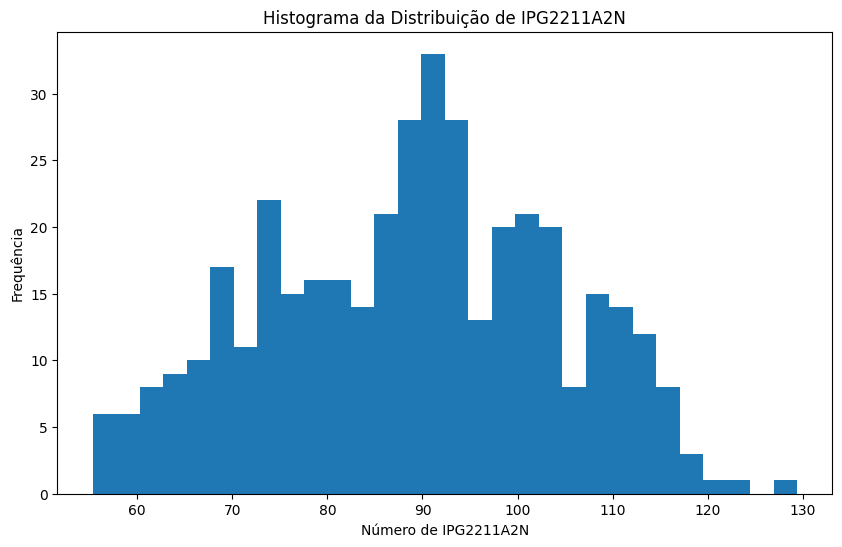

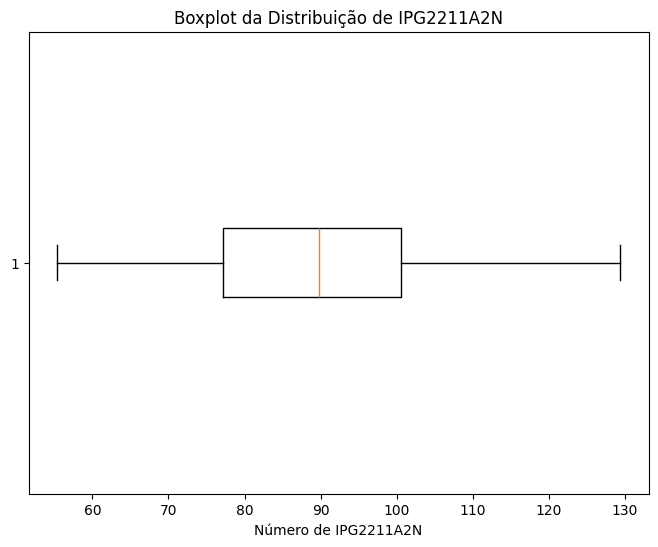

In [ ]:
calculate_descriptive_statistics(df, col='IPG2211A2N')

In [ ]:
plot_distribution(df, col='IPG2211A2N')

In [ ]:
#@title COLUNA DATE PARA NÚMERO

df['DATE'] = pd.to_datetime(df['DATE'])

In [ ]:
#@title CHECANDO VALORES NULOS

if df.isnull().values.any() == True:
    df = df.bfill()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        397 non-null    datetime64[ns]
 1   IPG2211A2N  397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB
None
                                DATE  IPG2211A2N
count                            397  397.000000
mean   2001-07-01 13:25:14.357682560   88.847218
min              1985-01-01 00:00:00   55.315100
25%              1993-04-01 00:00:00   77.105200
50%              2001-07-01 00:00:00   89.779500
75%              2009-10-01 00:00:00  100.524400
max              2018-01-01 00:00:00  129.404800
std                              NaN   15.387834


<Axes: >

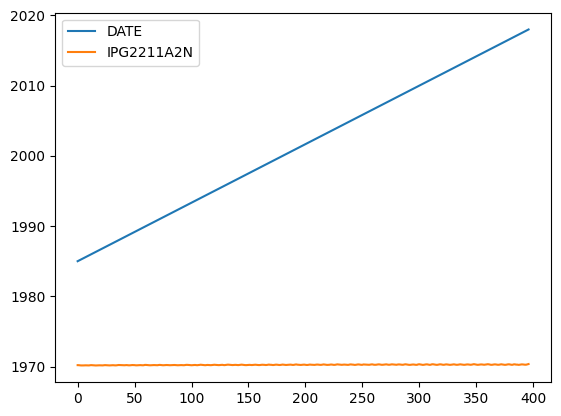

In [ ]:
#@title INFORMAÇÕES SOBRE O DATASET

print(df.info())
print(df.describe())
df.plot()


## Preparação de Dados

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential

In [ ]:
#@title DIVISÃO DOS DADOS SEM SHUFFLE >> train_test_split
from sklearn.model_selection import train_test_split

def dataset_split(df):
  df_train, df_rem = train_test_split(df, train_size=0.5, shuffle=False)
  df_val, df_test = train_test_split(df_rem, test_size=0.5, shuffle=False)
  return df_train, df_val, df_test


In [ ]:
df_train, df_val, df_test = dataset_split(df)
print("Tamanho do conjunto de treino:", len(df_train))
print("Tamanho do conjunto de validação:", len(df_val))
print("Tamanho do conjunto de teste:", len(df_test))

In [ ]:
#@title NORMALIZAÇÃO DOS DADOS >> MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

## normalização
# Fit apenas a coluna 'IPG2211A2N' no conjunto de treino
# a coluna DATE não é numérica
# notar a função fit apenas no conjunto de TREINO (df_train)

def min_max_scaler(df, col):

  scaler.fit(df_train[[col]])
  train_norm = scaler.transform(df_train[[col]])
  val_norm = scaler.transform(df_val[[col]])
  test_norm = scaler.transform(df_test[[col]])
  return train_norm, val_norm, test_norm

In [ ]:
train_norm, val_norm, test_norm = min_max_scaler(df, col='IPG2211A2N')
# ----------------------------------------------------------------------
plt.plot(np.concatenate([train_norm, val_norm, test_norm]))
plt.axhline(y=1.0, c="r", linewidth=2, linestyle = '--')
plt.axhline(y=0.0, c="r", linewidth=2, linestyle = '--')
plt.axvline(x=len(df_train), c="orange", linewidth=2, linestyle = '--')

'\nNOTA SOBRE AS FUNÇÕES FIT E TRANSFORM (FROM GEMINI):\n\nImagine that you\'re teaching a computer to understand the concept of "cold." \nYou show it a bunch of temperature readings (your training data), and it learns \nthat numbers below 10 degrees Celsius are generally considered cold.\n\n.fit() is like the computer learning from those examples. It figures out \nthe rules for what "cold" means based on the data you give it. In the case of MinMaxScaler, .fit() calculates the minimum and maximum values of your data.\n\n.transform() is like the computer applying those rules to new temperature \nreadings. It takes a new temperature and tells you if it\'s "cold" or not \nbased on what it learned from .fit(). With MinMaxScaler, .transform() actually \nscales the data to the range 0 to 1 using the minimum and maximum values it calculated earlier.\n\nHere\'s an analogy with baking a cake:\n\n.fit(): Looking at your recipe and gathering all the ingredients and tools. \nYou\'re preparing to b

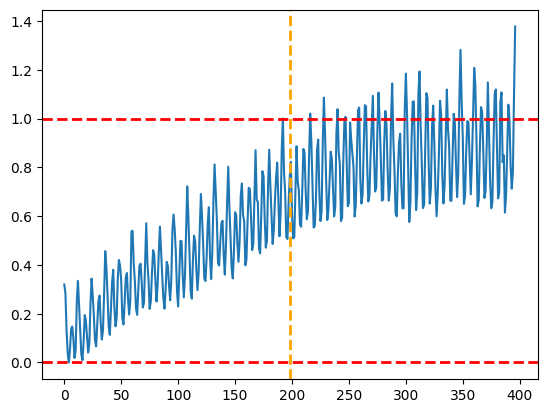

In [ ]:
"""
NOTA SOBRE AS FUNÇÕES FIT E TRANSFORM (FROM GEMINI):

Imagine that you're teaching a computer to understand the concept of "cold."
You show it a bunch of temperature readings (your training data), and it learns
that numbers below 10 degrees Celsius are generally considered cold.

.fit() is like the computer learning from those examples. It figures out
the rules for what "cold" means based on the data you give it. In the case of MinMaxScaler, .fit() calculates the minimum and maximum values of your data.

.transform() is like the computer applying those rules to new temperature
readings. It takes a new temperature and tells you if it's "cold" or not
based on what it learned from .fit(). With MinMaxScaler, .transform() actually
scales the data to the range 0 to 1 using the minimum and maximum values it calculated earlier.

Here's an analogy with baking a cake:

.fit(): Looking at your recipe and gathering all the ingredients and tools.
You're preparing to bake, but you haven't actually started yet.
.transform(): Actually mixing the ingredients and baking the cake according
to the recipe.
In the context of MinMaxScaler:

.fit(): Calculates the minimum and maximum values from your data. This is
like "learning" the scale of your data.
.transform(): Applies the scaling to your data by subtracting the minimum and
dividing by the range (maximum - minimum). This transforms your data to a
specific range (usually 0 to 1).

"""

In [ ]:
#@title FUNÇÃO JANELA DESLIZANTES (LAGS)

"""
uma rede LSTM para análise da série temporal em df_COMP para
previsão da coluna df_COMP.LEITOS SUS. Com uma camada LSTM para processar a
sequência temporal, uma camada densa para conectar a saída da LSTM à camada de
saída e um único neurônio com função de ativação linear para prever o número
de leitos disponíveis (df_COMP.LEITOS SUS) no cenário do próximo passo.

"""
# ------------------------------------------------------------------------ #
"""
A função create_sequences cria as sequencias seq_lenght de dados de treinamento.
E utiliza como entrada (features X) para predizer o valor da coluna de saida (y).

Ela cria uma pequena sequencia de comprimento especificado e desliza nos dados
um passo por vez. Cada pequena sequencia se torna o input (X) e os dados
imediatos a ela seguem (y).


"""

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

## Modelagem

### MODELO LSTM

In [ ]:
#@title CRIAÇÃO E TREINO MODELO LSTM

seq_length = 30 # VARIÁVEL PARA função creat_sequences

# Prepara os dados de treinamento
train_data = train_norm.flatten()
X_train_lstm, y_train_lstm = create_sequences(train_data, seq_length)

# Prepara os dados de validação
val_data = val_norm.flatten()
X_val_lstm, y_val_lstm = create_sequences(val_data, seq_length)

# Prepara os dados de teste
test_data = test_norm.flatten()
X_test_lstm, y_test_lstm = create_sequences(test_data, seq_length)

# --------------------- CRIAÇÃO DO MODELO LSTM ---------------------------- #

model_lstm = keras.Sequential() # >> INICIALIZA O MODELO SEQUENCIAL


# Primeira camada LSTM (adicionando return_sequences=True)
model_lstm.add(layers.LSTM(units=50,
                     activation='relu',
                     return_sequences=False,
                     input_shape=(X_train_lstm.shape[1], 1)))


# CAMADA DENSA COM ATIVAÇÃO LINEAR PARA PREDIÇÃO
model_lstm.add(layers.Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_val_lstm, y_val_lstm))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - loss: 0.1538 - val_loss: 0.3255
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0884 - val_loss: 0.1645
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0470 - val_loss: 0.0270
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0197 - val_loss: 0.0863
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0230 - val_loss: 0.0269
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0159 - val_loss: 0.0361
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0178 - val_loss: 0.0304
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0160 - val_loss: 0.0267
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0185 - val_loss: 0.0269
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0185 - val_loss: 0.0270
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0181 - val_loss: 0.0266
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0160 - val_loss: 0.0266

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


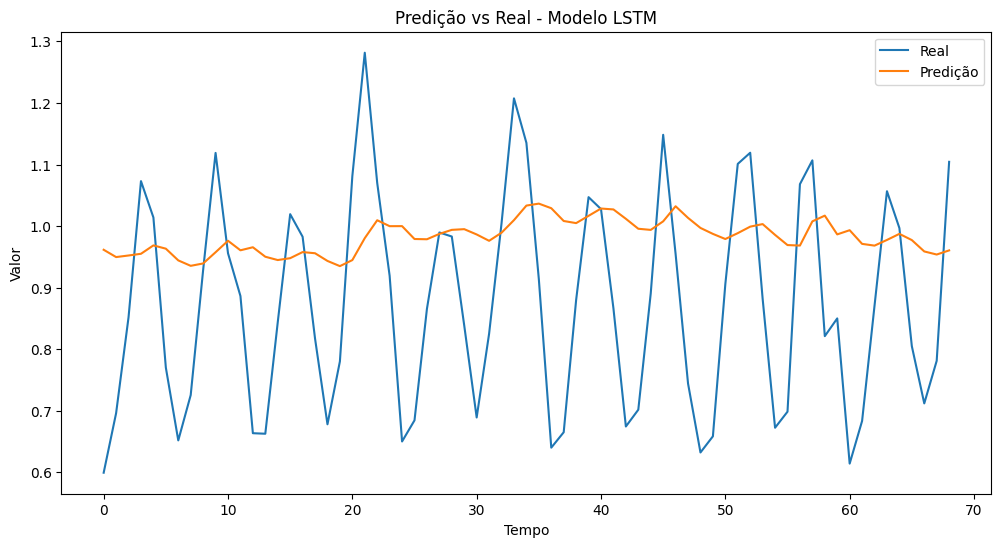

In [ ]:
#@title PREDIÇÃO DO MODELO LSTM

# Predição usando o modelo treinado
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Plotagem
plt.figure(figsize=(12, 6))
plt.plot(y_test_lstm, label='Real')
plt.plot(y_pred_lstm, label='Predição')
plt.legend()
plt.title('Predição vs Real - Modelo LSTM')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.show()

In [ ]:
#@title RESULTADOS LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular MSE
mse = mean_squared_error(y_test_lstm, y_pred_lstm)

# Calcular MAE
mae = mean_absolute_error(y_test_lstm, y_pred_lstm)

# Calcular RMSE
rmse = np.sqrt(mse)

print(f"Resultados para o modelo model_lstm:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

Resultados para o modelo model_lstm:
MSE: 0.04066475065641384
MAE: 0.16917542936787253
RMSE: 0.20165502883988248


### MODELO SVR

In [ ]:
#@title CRIAÇÃO E TREINO MODELO SVR
from sklearn.svm import SVR

seq_length = 1 # Previsão de um passo à frente >> Função creat_sequences()
X_train_svr, y_train_svr = create_sequences(train_norm.flatten(), seq_length)
X_val_svr, y_val_svr = create_sequences(val_norm.flatten(), seq_length)
X_test_svr, y_test_svr = create_sequences(test_norm.flatten(), seq_length)

# Treinamento do modelo SVR
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_rbf.fit(X_train_svr, y_train_svr)


SVR(C=100, gamma=0.1)

In [ ]:
#@title PREDIÇÃO MODELO SVR

# Previsões
y_pred_train = svr_rbf.predict(X_train_svr)
y_pred_val = svr_rbf.predict(X_val_svr)
y_pred_test = svr_rbf.predict(X_test_svr)

In [ ]:
#@title RESULTADOS SVR

# Avaliação do modelo SVR
mse_svr = mean_squared_error(y_test_svr, y_pred_test)
mae_svr = mean_absolute_error(y_test_svr, y_pred_test)
rmse_svr = np.sqrt(mse_svr)

print(f"Resultados para o modelo model_svr:")
print(f"MSE: {mse_svr}")
print(f"MAE: {mae_svr}")
print(f"RMSE: {rmse_svr}")

Resultados para o modelo model_svr:
MSE: 0.03506748686218203
MAE: 0.15350676259238408
RMSE: 0.18726314870305377


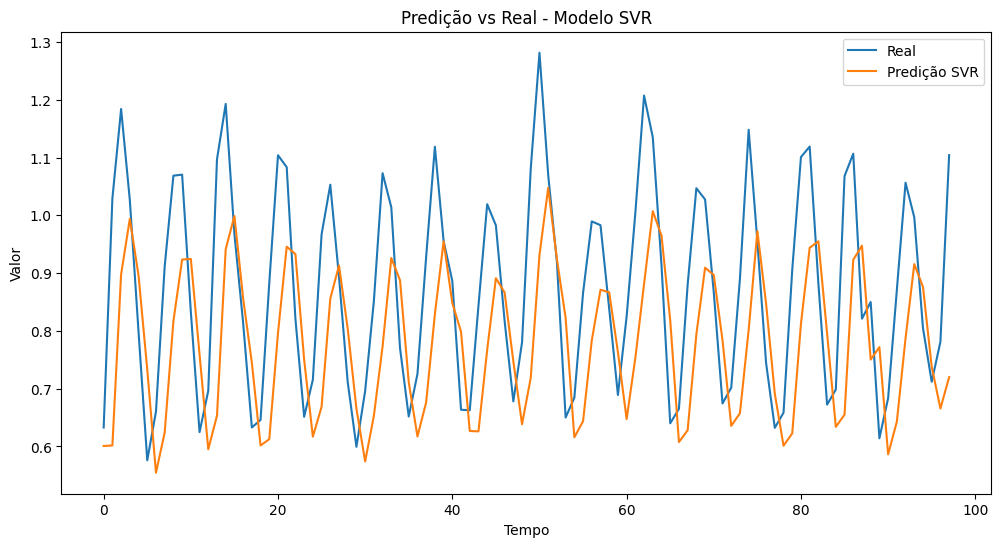

In [ ]:
# gráfico predições modelo SVR

plt.figure(figsize=(12, 6))
plt.plot(y_test_svr, label='Real')
plt.plot(y_pred_test, label='Predição SVR')
plt.legend()
plt.title('Predição vs Real - Modelo SVR')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.show()



### MODELO CNN

In [ ]:
#@title TREINAR MODELO CNN

# reshape dos dados para o formato (samples, timesteps, features)
X_train_cnn = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_val_cnn = X_val_lstm.reshape(X_val_lstm.shape[0], X_val_lstm.shape[1], 1)
X_test_cnn = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)


# Define o modelo CNN
model_cnn = keras.Sequential()
model_cnn.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model_cnn.add(layers.MaxPooling1D(pool_size=2))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(units=50, activation='relu'))
model_cnn.add(layers.Dense(1)) # Camada de saída


# Compila o modelo
model_cnn.compile(optimizer='adam', loss='mean_squared_error')

# Exibe o resumo do modelo
model_cnn.summary()

# Treina o modelo
history_cnn = model_cnn.fit(X_train_cnn, y_train_lstm, epochs=30, batch_size=16, validation_split=0.3)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 28, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 896)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 50)                  │          44,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,157 (176.39 KB)

 Trainable params: 45,157 (176.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0954 - val_loss: 0.0580
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0214 - val_loss: 0.0232
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0132 - val_loss: 0.0096
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - val_loss: 0.0049
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 10/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 11/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 12/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 

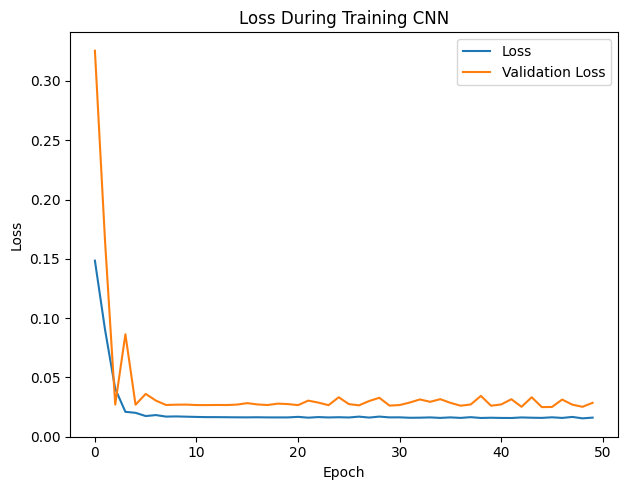

In [ ]:
#@title PLOTAGEM TREINAMENTO CNN
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


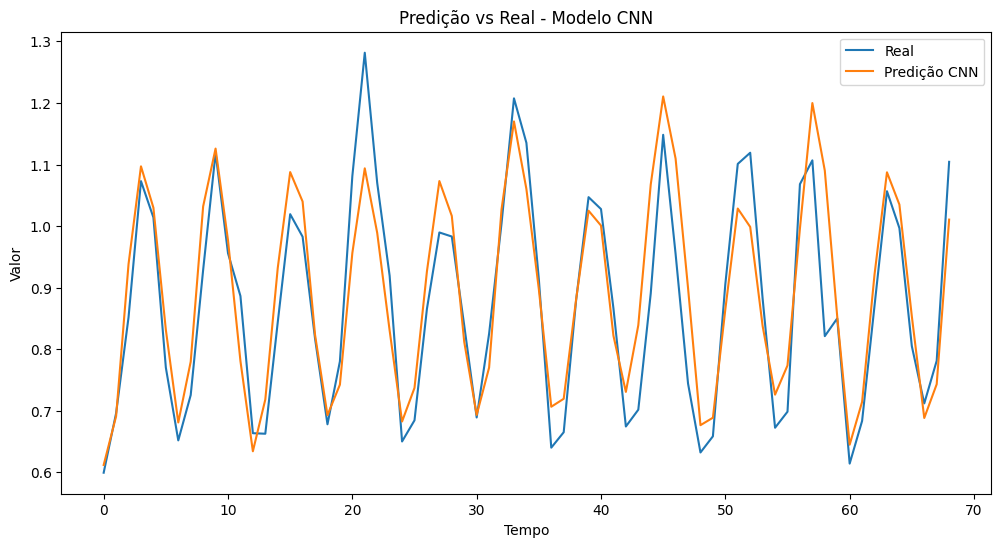

In [ ]:
#@title PREDIÇÃO MODELO CNN

# Faz a previsão usando o modelo CNN
y_pred_cnn = model_cnn.predict(X_test_cnn)

# Plota os resultados
plt.figure(figsize=(12, 6))
plt.plot(y_test_lstm, label='Real')
plt.plot(y_pred_cnn, label='Predição CNN')
plt.legend()
plt.title('Predição vs Real - Modelo CNN')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.show()

In [ ]:
#@title RESULTADOS ERROS CNN

# Calcular MSE
mse_cnn = mean_squared_error(y_test_lstm, y_pred_cnn)

# Calcular MAE
mae_cnn = mean_absolute_error(y_test_lstm, y_pred_cnn)

# Calcular RMSE
rmse_cnn = np.sqrt(mse_cnn)

print(f"Resultados para o modelo model_cnn:")
print(f"MSE: {mse_cnn}")
print(f"MAE: {mae_cnn}")
print(f"RMSE: {rmse_cnn}")

Resultados para o modelo model_cnn:
MSE: 0.005929198104602934
MAE: 0.0598235214404975
RMSE: 0.07700128638278021


In [ ]:
#@title CRIAÇÃO DO MODELO ARIMA

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Convert the normalized data back to a Pandas Series for ARIMA
train_data = pd.Series(train_norm.flatten(), index=df_train.index)
val_data = pd.Series(val_norm.flatten(), index=df_val.index)
test_data = pd.Series(test_norm.flatten(), index=df_test.index)

# Define the ARIMA model order (p, d, q) - these values may need to be adjusted
# Experiment with different values for p, d, q to optimize performance.
# Use tools like ACF and PACF plots to help guide your choice.

order = (5, 1, 0)

# Train the ARIMA model on the training data
model = ARIMA(train_data, order=order)
model_fit = model.fit()

# Make predictions on the validation and test sets
# Correct the prediction range for the test set
predictions_val = model_fit.predict(start=len(train_data), end=len(train_data) + len(val_data) - 1)
# Update the start and end parameters for test set prediction to cover the entire test set
predictions_test = model_fit.predict(start=len(train_data) + len(val_data), end=len(train_data) + len(val_data) + len(test_data) - 1) # Corrected prediction range for test set



# Série 2: Cotação Dólar

In [ ]:
df = pd.read_csv(
    '/content/drive/MyDrive/ProjetoDadosTabulares/USD_BRL Dados Históricos.csv',
    sep=',',
    encoding='utf-8',
    decimal=",",
    dtype={"Data": str, "Último": float, "Abertura": float, "Máxima": float, "Mínima": float, "Var%": str},
    )

In [ ]:
df.columns = ['data', 'fechamento', 'abertura', 'max', 'min', 'var']

In [ ]:
target_col = "fechamento"

In [ ]:
df["data"] = pd.to_datetime(df["data"])

<ipython-input-24-7bb3eb2a2c17>:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["data"] = pd.to_datetime(df["data"])


In [ ]:
df.dtypes

,0
data,object
fechamento,float64
abertura,float64
max,float64
min,float64
var,object


## Estatística Descritiva

In [ ]:
df.sort_values(by='data', inplace=True)

In [ ]:
melted_df = df.drop(columns="var").melt(id_vars=['data'], var_name='variável', value_name='valor').sort_values(by='data')

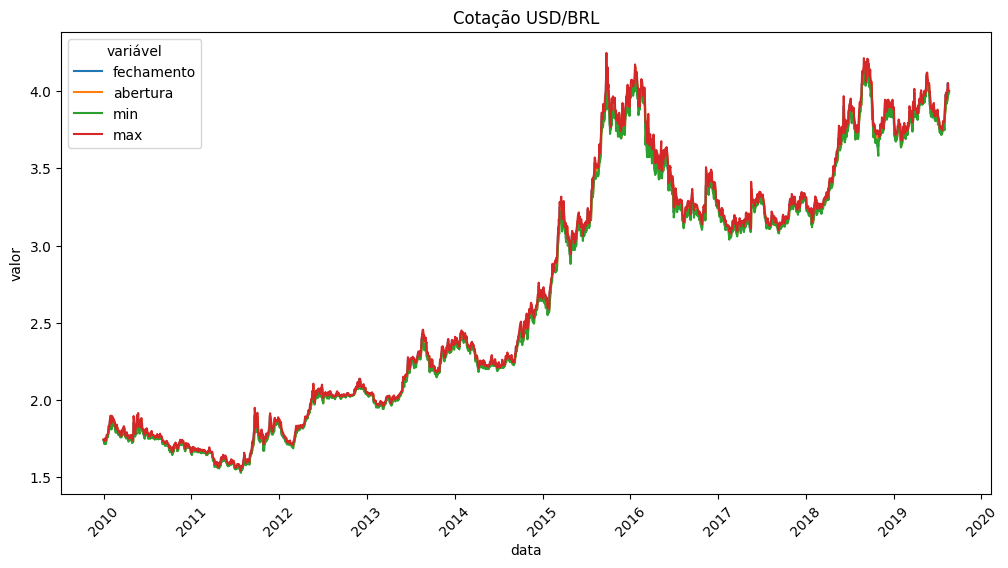

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x="data", y="valor", hue="variável", data=melted_df)
plt.xticks(rotation=45)
plt.title('Cotação USD/BRL')
plt.show()

In [ ]:
calculate_descriptive_statistics(df, col=target_col)

count    2512.000000
mean        2.699464
std         0.810919
min         1.538300
25%         1.969375
50%         2.481200
75%         3.342700
max         4.207700
Name: fechamento, dtype: float64

Média de fechamento: 2.699464132165605
Mediana de fechamento: 2.4812000000000003
Desvio Padrão de fechamento: 0.8109185276745188

Outliers (IQR):
Empty DataFrame
Columns: [data, fechamento, abertura, max, min, var]
Index: []


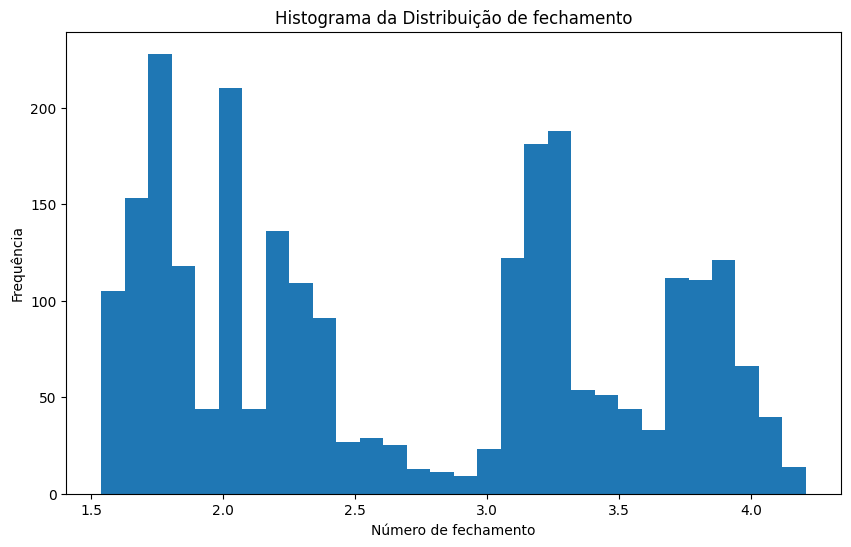

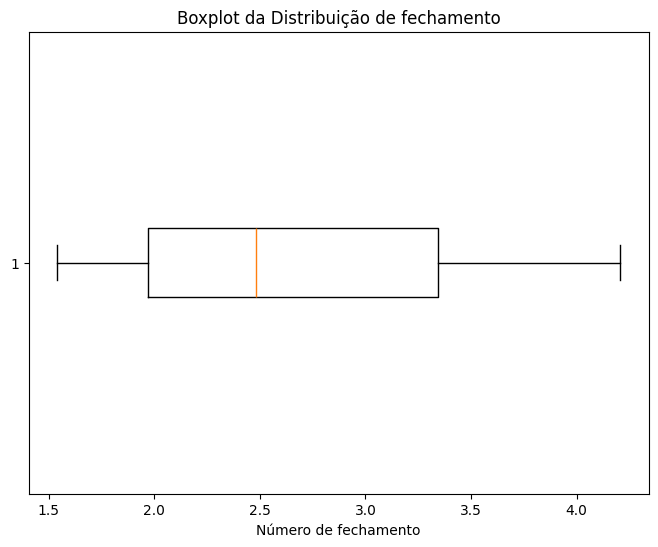

In [ ]:
plot_distribution(df, col=target_col)

## Preparação de Dados

In [ ]:
df_train, df_val, df_test = dataset_split(df)
print("Tamanho do conjunto de treino:", len(df_train))
print("Tamanho do conjunto de validação:", len(df_val))
print("Tamanho do conjunto de teste:", len(df_test))

Tamanho do conjunto de treino: 1256
Tamanho do conjunto de validação: 628
Tamanho do conjunto de teste: 628


Normalização

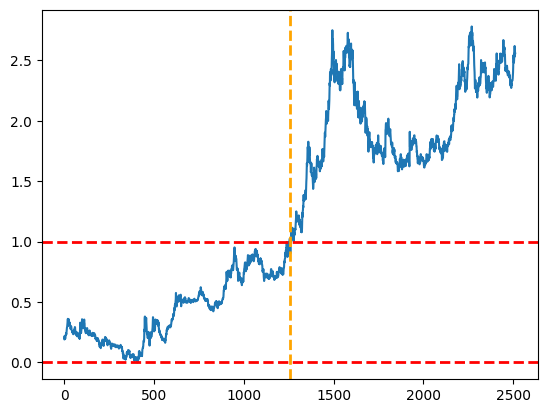

In [ ]:
train_norm, val_norm, test_norm = min_max_scaler(df, col=target_col)
# ----------------------------------------------------------------------
plt.plot(np.concatenate([train_norm, val_norm, test_norm]))
plt.axhline(y=1.0, c="r", linewidth=2, linestyle = '--')
plt.axhline(y=0.0, c="r", linewidth=2, linestyle = '--')
plt.axvline(x=len(df_train), c="orange", linewidth=2, linestyle = '--')

## Modelagem

### Modelo LSTM

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
seq_length = 40 # VARIÁVEL de Lag

# Prepara os dados de treinamento
train_data = train_norm.flatten()
X_train_lstm, y_train_lstm = create_sequences(train_data, seq_length)

# Prepara os dados de validação
val_data = val_norm.flatten()
X_val_lstm, y_val_lstm = create_sequences(val_data, seq_length)

# Prepara os dados de teste
test_data = test_norm.flatten()
X_test_lstm, y_test_lstm = create_sequences(test_data, seq_length)

In [ ]:
def build_lstm_model(units=50, activation='relu', optimizer='adam', learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.LSTM(units=units, activation=activation, return_sequences=False, input_shape=(seq_length, 1)))
    model.add(layers.Dense(units=1))

    # Compile the model
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mse')
    return model

In [ ]:
param_dist = {
    'units': [30, 50, 100],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150]
}
n_iter = 10  # Número de combinações
param_list = list(ParameterSampler(param_dist, n_iter=n_iter))

In [ ]:
#@title RandomSearch

best_loss = float('inf')
best_params = None
best_model = None

for params in param_list:
    print(f"Testing params: {params}")

    model = build_lstm_model(
        units=params['units'],
        activation=params['activation'],
        optimizer=params['optimizer'],
        learning_rate=params['learning_rate']
    )

    history = model.fit(
        X_train_lstm, y_train_lstm,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_data=(X_val_lstm, y_val_lstm),
        verbose=0
    )

    # Avaliação no set de validação
    val_loss = model.evaluate(X_val_lstm, y_val_lstm, verbose=0)
    print(f"Validation Loss: {val_loss}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = params
        best_model = model
        print("Parametros atualizados...")

Testing params: {'units': 50, 'optimizer': 'rmsprop', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'activation': 'relu'}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss: 9.504149056738243e-05
Parametros atualizados...
Testing params: {'units': 30, 'optimizer': 'rmsprop', 'learning_rate': 0.1, 'epochs': 100, 'batch_size': 64, 'activation': 'tanh'}
Validation Loss: 0.04534996300935745
Testing params: {'units': 100, 'optimizer': 'adam', 'learning_rate': 0.01, 'epochs': 50, 'batch_size': 32, 'activation': 'tanh'}
Validation Loss: 0.00025827897479757667
Testing params: {'units': 50, 'optimizer': 'adam', 'learning_rate': 0.1, 'epochs': 150, 'batch_size': 32, 'activation': 'relu'}
Validation Loss: nan
Testing params: {'units': 50, 'optimizer': 'adam', 'learning_rate': 0.001, 'epochs': 150, 'batch_size': 16, 'activation': 'relu'}
Validation Loss: 0.0003744988644029945
Testing params: {'units': 30, 'optimizer': 'rmsprop', 'learning_rate': 0.1, 'epochs': 150, 'batch_size': 16, 'activation': 'tanh'}
Validation Loss: 0.03072415664792061
Testing params: {'units': 100, 'optimizer': 'rmsprop', 'learning_rate': 0.01, 'epochs': 150, 'batch_size': 32, '

In [ ]:
print("Parâmetros ótimos: ", best_params)

test_loss = best_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"Test Loss: {test_loss}")

Parâmetros ótimos:  {'units': 50, 'optimizer': 'rmsprop', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'activation': 'relu'}
Test Loss: 8.909362804843113e-05


In [ ]:
#@title Treinando modelo com melhores parâmetros
X_full_train = np.concatenate((X_train_lstm, X_val_lstm), axis=0)
y_full_train = np.concatenate((y_train_lstm, y_val_lstm), axis=0)

best_model.fit(
    X_full_train, y_full_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1
)

final_test_loss = best_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"Final Test Loss: {final_test_loss}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 8.8416e-04
Epoch 24/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 7.3128e-04
Epoch 25/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 7.6608e-04
Epoch 26/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 7.5124e-04
Epoch 27/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 7.7834e-04
Epoch 28/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 6.7146e-04
Epoch 29/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 7.1452e-04
Epoch 30/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 7.1500e-04
Epoch 31/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 6.5408e-04
Epoch 32/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 6.7957e-04
Epoch 33/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 6.0828e-04
Epoch 34/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 6.7666e-04
Epoch 35/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 7.9516e-04
Epoch 36/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/s

In [ ]:
best_model.save("/content/drive/MyDrive/ProjetoDadosTabulares/LTSM.h5")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


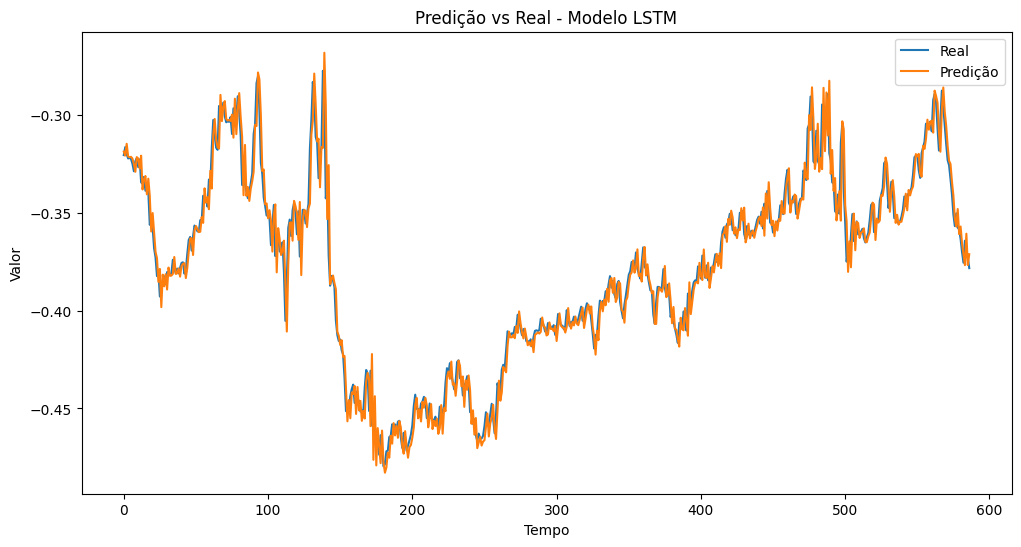

In [ ]:
#@title PREDIÇÃO DO MODELO LSTM

# Predição usando o modelo treinado
y_pred_lstm = best_model.predict(X_test_lstm)

# Plotagem
plt.figure(figsize=(12, 6))
plt.plot(y_test_lstm, label='Real')
plt.plot(y_pred_lstm, label='Predição')
plt.legend()
plt.title('Predição vs Real - Modelo LSTM')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.show()

In [ ]:
#@title RESULTADOS LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular MSE
mse = mean_squared_error(y_test_lstm, y_pred_lstm)

# Calcular MAE
mae = mean_absolute_error(y_test_lstm, y_pred_lstm)

# Calcular RMSE
rmse = np.sqrt(mse)

print(f"Resultados para o modelo model_lstm:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

Resultados para o modelo model_lstm:
MSE: 9.105205046576021e-05
MAE: 0.006782846853051404
RMSE: 0.009542119809861969


### MODELO SVR

In [ ]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform

In [ ]:
seq_length = 1 # Previsão de um passo à frente >> Função creat_sequences()
X_train_svr, y_train_svr = create_sequences(train_norm.flatten(), seq_length)
X_val_svr, y_val_svr = create_sequences(val_norm.flatten(), seq_length)
X_test_svr, y_test_svr = create_sequences(test_norm.flatten(), seq_length)

In [ ]:
#@title Modelo SVR com RandomSearch
param_dist = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': loguniform(1e-1, 1e3),
    'gamma': loguniform(1e-4, 1e1),
    'epsilon': uniform(0.01, 0.2)
}

svr = SVR()

# random search
n_iter = 50  # Número de trials
random_search = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_dist,
    n_iter=n_iter,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
random_search.fit(X_train_svr, y_train_svr)

best_svr = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Parameters: ", best_params)

val_score = best_svr.score(X_val_svr, y_val_svr)
print(f"Validation R^2 Score: {val_score}")

test_score = best_svr.score(X_test_svr, y_test_svr)
print(f"Test R^2 Score: {test_score}")

X_full_train = np.concatenate((X_train_svr, X_val_svr), axis=0)
y_full_train = np.concatenate((y_train_svr, y_val_svr), axis=0)
best_svr.fit(X_full_train, y_full_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters:  {'C': 0.3125387839122242, 'epsilon': 0.017623391063640075, 'gamma': 0.0005538885617236509, 'kernel': 'linear'}
Validation R^2 Score: 0.9855358937755154
Test R^2 Score: 0.9693196416854909


SVR(C=0.3125387839122242, epsilon=0.017623391063640075,
    gamma=0.0005538885617236509, kernel='linear')

In [ ]:
#@title PREDIÇÃO MODELO SVR

# Previsões
y_pred_train = best_svr.predict(X_train_svr)
y_pred_val = best_svr.predict(X_val_svr)
y_pred_test = best_svr.predict(X_test_svr)

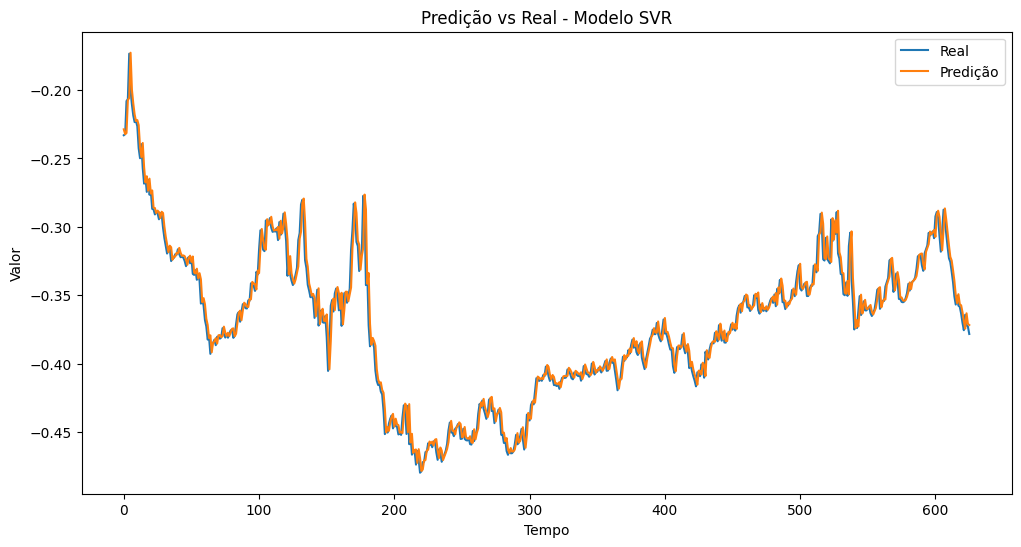

In [ ]:
# Plotagem
plt.figure(figsize=(12, 6))
plt.plot(y_test_svr, label='Real')
plt.plot(y_pred_test, label='Predição')
plt.legend()
plt.title('Predição vs Real - Modelo SVR')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.show()

In [ ]:
#@title RESULTADOS SVR

# Avaliação do modelo SVR
mse_svr = mean_squared_error(y_test_svr, y_pred_test)
mae_svr = mean_absolute_error(y_test_svr, y_pred_test)
rmse_svr = np.sqrt(mse_svr)

print(f"Resultados para o modelo model_svr:")
print(f"MSE: {mse_svr}")
print(f"MAE: {mae_svr}")
print(f"RMSE: {rmse_svr}")

Resultados para o modelo model_svr:
MSE: 0.003283530693277405
MAE: 0.05635069288380702
RMSE: 0.057302100251887846


### MODELO CNN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import ParameterSampler

In [ ]:
# Define the CNN model creation function
def build_cnn_model(filters=64, kernel_size=3, dense_units=50, activation='relu', optimizer='adam', learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train_cnn.shape[1], 1)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=dense_units, activation=activation))
    model.add(layers.Dense(1))

    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

In [ ]:
# reshape dos dados para o formato (samples, timesteps, features)
X_train_cnn = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_val_cnn = X_val_lstm.reshape(X_val_lstm.shape[0], X_val_lstm.shape[1], 1)
X_test_cnn = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

In [ ]:
#@title Implementando CNN com RandomSearch
param_dist = {
    'filters': [32, 64, 128],
    'kernel_size': [2, 3, 5],
    'dense_units': [50, 100, 200],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'epochs': [30, 50, 100]
}

n_iter = 10
param_list = list(ParameterSampler(param_dist, n_iter=n_iter))

# Random Search
best_loss = float('inf')
best_params = None
best_model = None

for params in param_list:
    print(f"Testing params: {params}")

    model = build_cnn_model(
        filters=params['filters'],
        kernel_size=params['kernel_size'],
        dense_units=params['dense_units'],
        activation=params['activation'],
        optimizer=params['optimizer'],
        learning_rate=params['learning_rate']
    )

    history = model.fit(
        X_train_cnn, y_train_lstm,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_data=(X_val_cnn, y_val_lstm),
        verbose=0
    )

    val_loss = model.evaluate(X_val_cnn, y_val_lstm, verbose=0)
    print(f"Validation Loss: {val_loss}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = params
        best_model = model
        print("New best model found!")


Testing params: {'optimizer': 'adam', 'learning_rate': 0.01, 'kernel_size': 5, 'filters': 32, 'epochs': 100, 'dense_units': 200, 'batch_size': 64, 'activation': 'tanh'}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Loss: 0.0001836735027609393
New best model found!
Testing params: {'optimizer': 'rmsprop', 'learning_rate': 0.1, 'kernel_size': 2, 'filters': 64, 'epochs': 50, 'dense_units': 200, 'batch_size': 32, 'activation': 'tanh'}
Validation Loss: 84.54367065429688
Testing params: {'optimizer': 'adam', 'learning_rate': 0.001, 'kernel_size': 5, 'filters': 64, 'epochs': 30, 'dense_units': 200, 'batch_size': 16, 'activation': 'tanh'}
Validation Loss: 9.49622190091759e-05
New best model found!
Testing params: {'optimizer': 'adam', 'learning_rate': 0.001, 'kernel_size': 2, 'filters': 128, 'epochs': 50, 'dense_units': 100, 'batch_size': 64, 'activation': 'tanh'}
Validation Loss: 0.000374020601157099
Testing params: {'optimizer': 'adam', 'learning_rate': 0.01, 'kernel_size': 3, 'filters': 128, 'epochs': 50, 'dense_units': 100, 'batch_size': 16, 'activation': 'relu'}
Validation Loss: 0.041829559952020645
Testing params: {'optimizer': 'rmsprop', 'learning_rate': 0.01, 'kernel_size': 5, 'filters

In [ ]:
print("Parâmetros ótimos CNN: ", best_params)

Parâmetros ótimos CNN:  {'optimizer': 'adam', 'learning_rate': 0.001, 'kernel_size': 5, 'filters': 64, 'epochs': 30, 'dense_units': 200, 'batch_size': 16, 'activation': 'tanh'}


In [ ]:
best_params =  {'optimizer': 'adam', 'learning_rate': 0.001, 'kernel_size': 5, 'filters': 64, 'epochs': 30, 'dense_units': 200, 'batch_size': 16, 'activation': 'tanh'}

In [ ]:
# Retreino com todos os dados de treino e validação
X_full_train = np.concatenate((X_train_cnn, X_val_cnn), axis=0)
y_full_train = np.concatenate((y_train_lstm, y_val_lstm), axis=0)
best_model.fit(X_full_train, y_full_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3631
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0044
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0043
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0129
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0026
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0051
Epoch 9/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0020
Epoch 10/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026
Epoch 11/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018
Epoch 12/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022
Epoch 13/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0031
Epoch 14/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051
Epoch 15/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


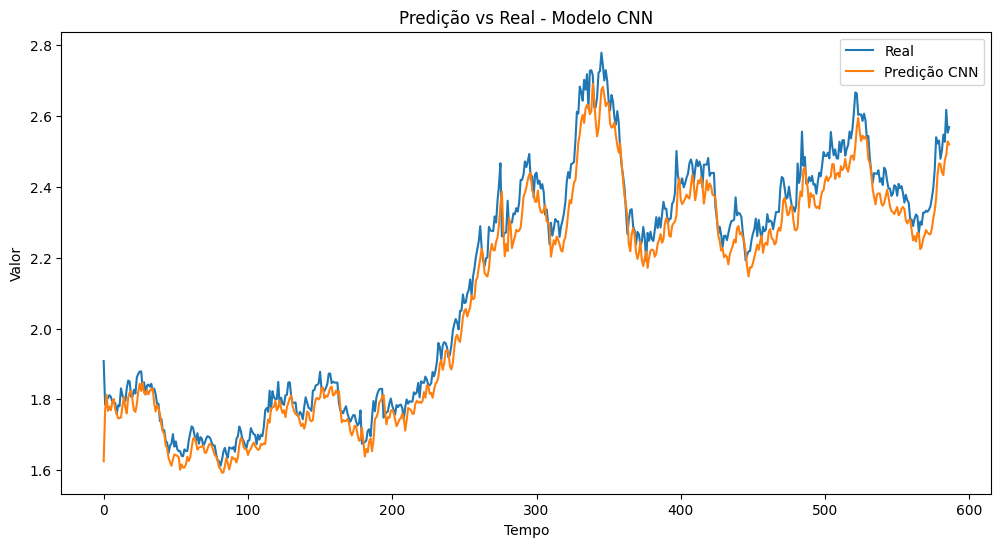

In [ ]:
#@title PREDIÇÃO MODELO CNN

# Faz a previsão usando o modelo CNN
y_pred_cnn = best_model.predict(X_test_cnn)

# Plota os resultados
plt.figure(figsize=(12, 6))
plt.plot(y_test_lstm, label='Real')
plt.plot(y_pred_cnn, label='Predição CNN')
plt.legend()
plt.title('Predição vs Real - Modelo CNN')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.show()

In [ ]:
#@title RESULTADOS ERROS CNN
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular MSE
mse_cnn = mean_squared_error(y_test_lstm, y_pred_cnn)

# Calcular MAE
mae_cnn = mean_absolute_error(y_test_lstm, y_pred_cnn)

# Calcular RMSE
rmse_cnn = np.sqrt(mse_cnn)

print(f"Resultados para o modelo model_cnn:")
print(f"MSE: {mse_cnn}")
print(f"MAE: {mae_cnn}")
print(f"RMSE: {rmse_cnn}")

Resultados para o modelo model_cnn:
MSE: 0.0036308397827601218
MAE: 0.049373044910369236
RMSE: 0.0602564501340738


### Modelo Arima

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.7 MB/s eta 0:00:00


In [ ]:
# @title ARIMA
from pmdarima import auto_arima

arima_train = pd.concat([df_train, df_val])[target_col]
arima_test = df_test[target_col]

model = auto_arima(arima_train, seasonal=True, trace=True)
print(model.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8254.181, Time=9.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8232.944, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8236.838, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8237.800, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8233.642, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8235.465, Time=1.61 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8242.804, Time=3.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-8239.066, Time=4.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-8252.944, Time=4.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8240.868, Time=1.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-8240.167, Time=2.85 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-8241.442, Time=3.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-8247.554, Time=6.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-8254.856, Time=1.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-8242.600, Time=1.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8243.043, Time=0.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-8246.964, Time=1.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-8253.436, Time=6.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8239.885, Time=0.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-8240.451, Time=0.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-8241.812, Time=0.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-8251.517, Time=2.30 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 54.137 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1884
Model:               SARIMAX(2, 1, 2)   Log Likelihood                4132.428
Date:                Sat, 25 Jan 2025   AIC                          -8254.856
Time:                        12:28:10   BIC                          -8227.152
Sample:                             0   HQIC                         -8244.652
                               - 1884                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3261      0.062     -5.294      0.000      -0.44

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
forecast = model.predict(n_periods=len(arima_test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
arima_test.drop("predict", inplace=True)

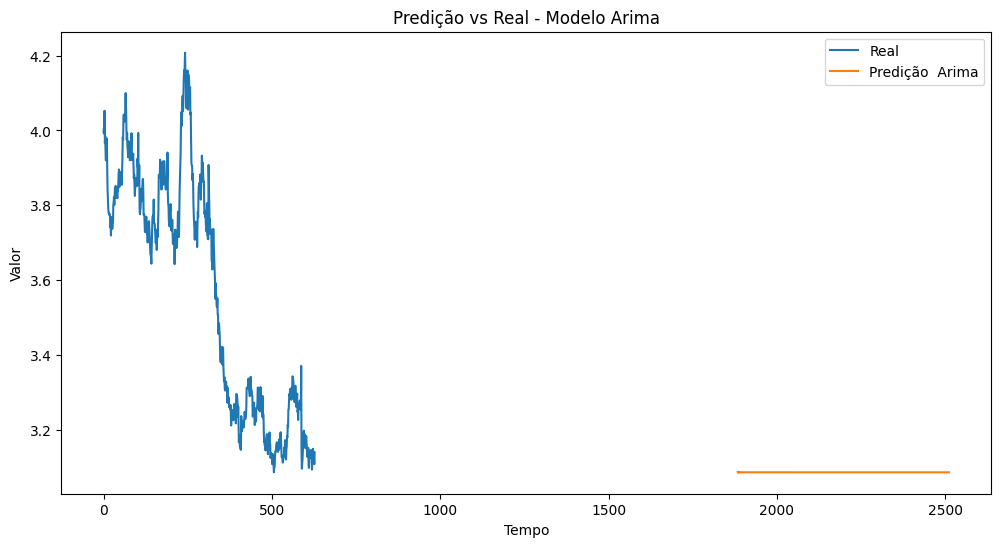

In [ ]:
#arima_test["predict"] = forecast
# Plota os resultados
plt.figure(figsize=(12, 6))
plt.plot(arima_test, label='Real')
plt.plot(forecast, label='Predição  Arima')
plt.legend()
plt.title('Predição vs Real - Modelo Arima')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.show()

In [ ]:
forecast

,0
1884,3.087286
1885,3.085635
1886,3.086710
1887,3.087600
1888,3.086502
...,...
2507,3.086750
2508,3.086750
2509,3.086750
2510,3.086750


In [ ]:
# @title Resultados ARIMA
result = get_results(arima_test, forecast)
results['arima'] = result

result

{'mse': 49.69, 'mae': 6.36, 'rmse': 49.69}

# Série 3: Média diária de temperatura

Link para o dataset: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

Este conjunto de dados fornece dados **diários** de 1º de janeiro de 2013 a 24 de abril de 2017 na cidade de Delhi, Índia. Os 4 parâmetros aqui são
* meantemp (temperatura média);
* moisture (umidade);
* wind_speed (velociadade do vento);
* meanpressure (pressão média).

Para este trabalho, será utilizado apenas o parâmetro **meantemp**

<Axes: xlabel='date'>

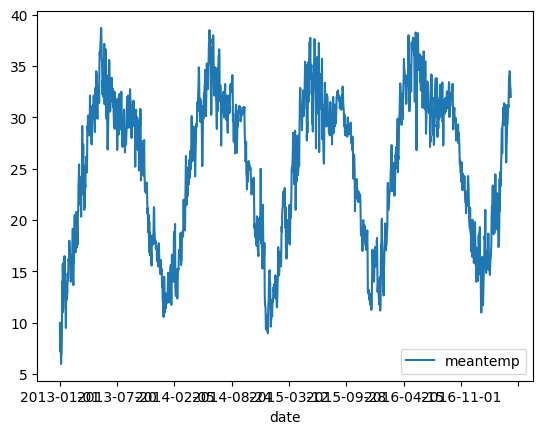

In [ ]:
df = pd.read_csv(
    '/content/drive/MyDrive/ProjetoDadosTabulares/DailyDelhiClimate.csv',
    sep=',',
    index_col="date",
    usecols=['date', 'meantemp'],
    encoding='utf-8'
)

target_col = 'meantemp'

df.plot()

In [ ]:
# @title Estatística descritiva

calculate_descriptive_statistics(df, col=target_col)

count    1575.000000
mean       25.231582
std         7.337316
min         6.000000
25%        18.516667
50%        27.166667
75%        31.142857
max        38.714286
Name: meantemp, dtype: float64

Média de meantemp: 25.231582346431566
Mediana de meantemp: 27.166666666666668
Desvio Padrão de meantemp: 7.337316080532334

Outliers (IQR):
Empty DataFrame
Columns: [meantemp]
Index: []


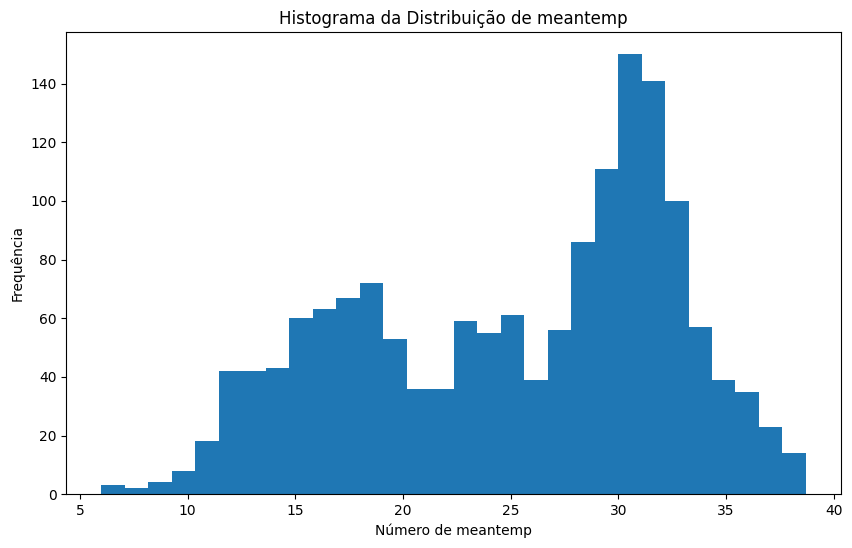

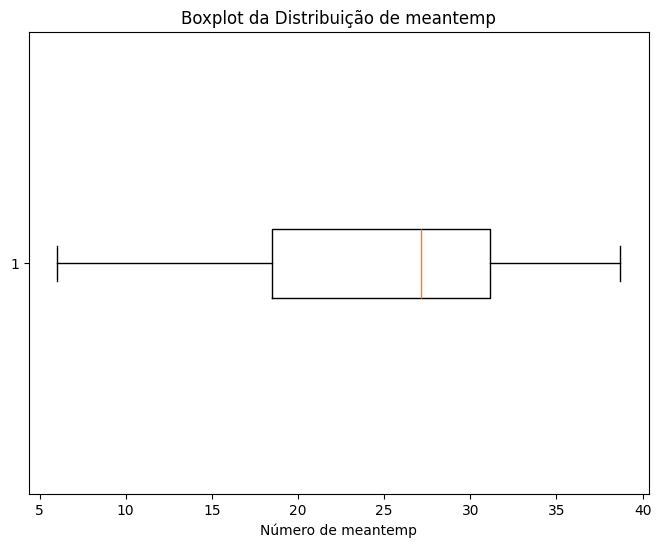

In [ ]:
# @title Distribuição da série

plot_distribution(df, col=target_col)

Tamanho do conjunto de treino: 1181
Tamanho do conjunto de teste: 394


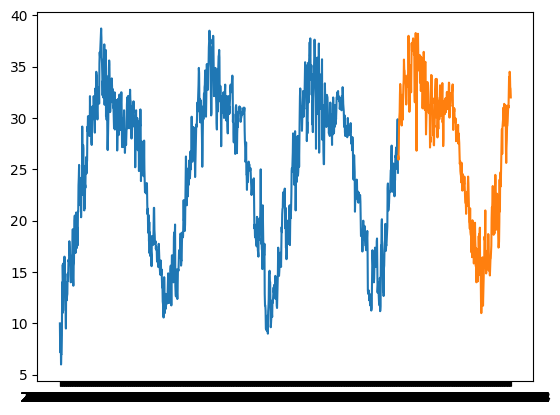

In [ ]:
# @title Split dos dados

df_train, df_test = train_test_split(df, test_size=0.25, shuffle=False)
plt.plot(df_train); plt.plot(df_test)


print("Tamanho do conjunto de treino:", len(df_train))
print("Tamanho do conjunto de teste:", len(df_test))

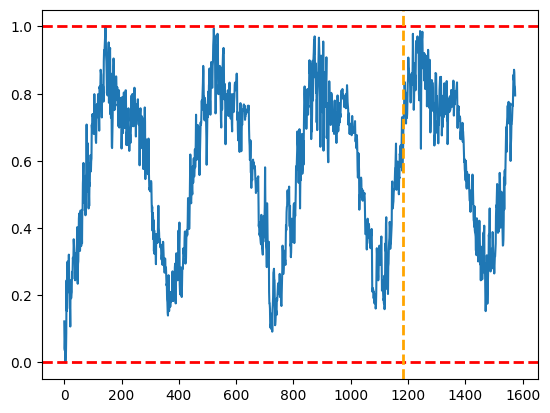

In [ ]:
# @title Normalização dos dados
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(df_train)
train_norm = scaler.transform(df_train)
test_norm = scaler.transform(df_test)

plt.plot(np.concatenate([train_norm, test_norm]))
plt.axhline(y=1.0, c="r", linewidth=2, linestyle = '--')
plt.axhline(y=0.0, c="r", linewidth=2, linestyle = '--')
plt.axvline(x=len(df_train), c="orange", linewidth=2, linestyle = '--')

In [ ]:
# @title Janelas deslizantes
seq_length = 30

train_data = train_norm.flatten()
X_train, y_train = create_sequences(train_data, seq_length)

test_data = test_norm.flatten()
X_test, y_test = create_sequences(test_data, seq_length)

In [ ]:
# @title Função LSTM builder
from tensorflow.keras.models import Sequential
from keras.layers import LSTM

def build_lstm_model(params):
    units = params['units'] if ('units' in params) else 50
    activation = params['activation'] if ('activation' in params) else 'relu'
    optimizer = params['optimizer'] if ('optimizer' in params) else 'adam'
    learning_rate = params['learning_rate'] if ('learning_rate' in params) else 0.001
    input_shape = params['input_shape'] if ('input_shape' in params) else (1, 1)

    model = Sequential()
    model.add(layers.LSTM(units=units, activation=activation, return_sequences=False, input_shape=input_shape))
    model.add(layers.Dense(units=1))

    # Compile the model
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mse')
    return model

In [ ]:
# @title Função SVR builder
from sklearn.svm import SVR

def build_svr_model(params):
    C = params['C'] if ('C' in params) else 1
    epsilon = params['epsilon'] if ('epsilon' in params) else 0.01
    kernel = params['kernel'] if ('kernel' in params) else 'linear'

    model = SVR(C=C, epsilon=epsilon, kernel=kernel)

    return model

In [ ]:
# @title Função CNN builder
from keras.layers import InputLayer, Conv1D, Dense, Flatten, MaxPooling1D

def build_cnn_model(params):
  optimizer = params['optimizer'] if ('optimizer' in params) else 'adam'
  input_shape = params['input_shape'] if ('input_shape' in params) else (1, 1)

  model = Sequential()
  model.add(Conv1D(filters=16, kernel_size=6, activation='relu', input_shape=input_shape))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

  return model

In [ ]:
# @title Função RandomSearch
from sklearn.model_selection import ParameterSampler
import tensorflow as tf
import statistics

def RandomSearch(params_dist, builder, X, y, n_iter = 10):
  param_list = list(ParameterSampler(params_dist, n_iter=n_iter))

  best_loss = float('inf')
  best_params = None
  best_model = None
  best_history = None
  best_score = 0

  for params in param_list:
      print(f"Testing params: {params}")

      model = builder(params)

      if ('epochs' in params) and ('batch_size' in params):
        epochs = params['epochs']
        batch_size = params['batch_size']

        history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.33, verbose=0)
        val_loss = statistics.mean(history.history['val_loss'])
        print(f"Validation Loss: {val_loss}")

        if val_loss < best_loss:
          best_loss = val_loss
          best_params = params
          best_model = model
          best_history = history
          print("New best model found!")
      else:
        model = model.fit(X, y)
        score = model.score(X, y)
        print(f"Score: {score}")

        if score > best_score:
          best_score = score
          best_params = params
          best_model = model


  print("Parâmetros ótimos: ", best_params)
  return best_model, best_history if best_history is not None else score

In [ ]:
# @title Função plot do treinamento

def training_plot(history):
  plt.figure(figsize=(12, 5))

  # Loss
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss During Training')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
# @title Função plot da predição

def prediction_plot(pred, y, model_name = 'Model'):
  plt.plot(y, label="Target")
  plt.plot(pred, label=model_name)
  plt.legend()

In [ ]:
# @title Função pegar resultados
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def get_results(y_test, pred):
  return {
    'mse': round(mean_squared_error(y_test, pred), 2),
    'mae': round(mean_absolute_error(y_test, pred), 2),
    'rmse': round(mean_squared_error(y_test, pred), 2)
  }

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Testing params: {'optimizer': 'adam', 'input_shape': (30, 1), 'epochs': 50, 'batch_size': 16}
Validation Loss: 0.004177599744871259
New best model found!
Testing params: {'optimizer': 'rmsprop', 'input_shape': (30, 1), 'epochs': 50, 'batch_size': 16}
Validation Loss: 0.005127571420744061
Parâmetros ótimos:  {'optimizer': 'adam', 'input_shape': (30, 1), 'epochs': 50, 'batch_size': 16}


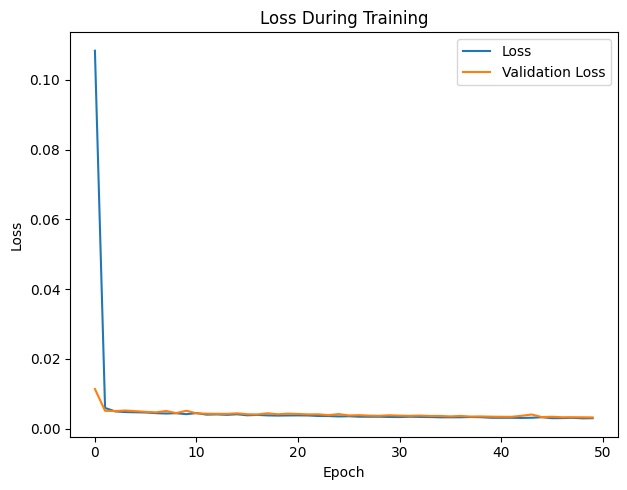

In [ ]:
# @title LSTM com RandomSearch
parameters = {
    'optimizer': ['adam', 'rmsprop'],
    'input_shape': [(seq_length, 1)],
    'epochs': [50],
    'batch_size': [16]
}

lstm_model, history = RandomSearch(parameters, build_lstm_model, np.expand_dims(X_train, axis=-1), y_train)
training_plot(history)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


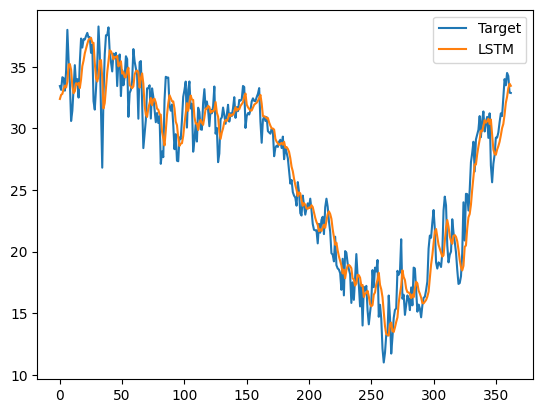

In [ ]:
# @title Predição LSTM
pred_lstm = lstm_model.predict(np.expand_dims(X_test, axis=-1))
pred_lstm = scaler.inverse_transform(pred_lstm)

prediction_plot(pred = pred_lstm, y = scaler.inverse_transform(y_test.reshape(-1, 1)), model_name = 'LSTM')

In [ ]:
# @title Resultados LSTM
results = {}

result = get_results(scaler.inverse_transform(y_test.reshape(-1, 1)), pred_lstm)
results['lstm'] = result

result

{'mse': 3.43, 'mae': 1.44, 'rmse': 3.43}

In [ ]:
# @title SVR com RandomSearch
parameters = {
    'epsilon': [0.01, 0.001],
}

svr_model, score = RandomSearch(parameters, build_svr_model, X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Testing params: {'epsilon': 0.01}
Score: 0.9510795720440939
Testing params: {'epsilon': 0.001}
Score: 0.9512397757878409
Parâmetros ótimos:  {'epsilon': 0.001}


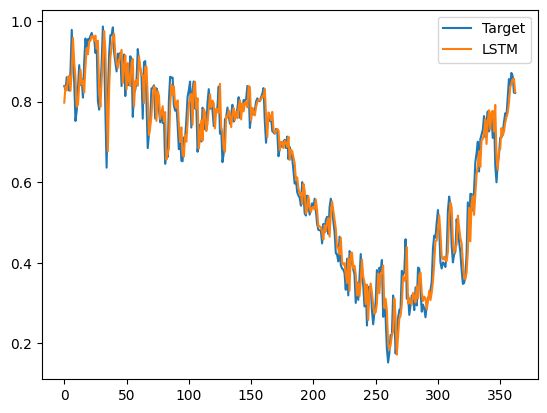

In [ ]:
# @title Predição SVR
pred_svr = svr_model.predict(X_test)
prediction_plot(pred = pred_svr, y = y_test, model_name = 'SVR')

In [ ]:
# @title Resultados SVR
result = get_results(y_test, pred_svr)
results['svr'] = result

result

{'mse': 0.0, 'mae': 0.04, 'rmse': 0.0}

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing params: {'optimizer': 'adam', 'input_shape': (30, 1), 'epochs': 50, 'batch_size': 16}
Validation Loss: 0.005350754726678133
New best model found!
Testing params: {'optimizer': 'rmsprop', 'input_shape': (30, 1), 'epochs': 50, 'batch_size': 16}
Validation Loss: 0.011179302670061588
Parâmetros ótimos:  {'optimizer': 'adam', 'input_shape': (30, 1), 'epochs': 50, 'batch_size': 16}


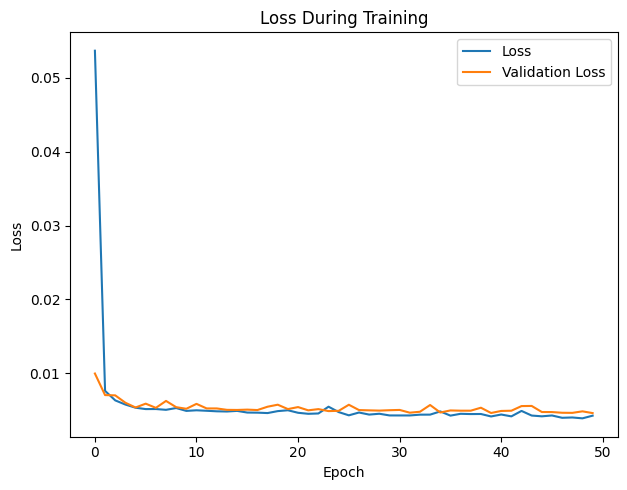

In [ ]:
# @title CNN com RandomSearch
parameters = {
    'optimizer': ['adam', 'rmsprop'],
    'input_shape': [(seq_length, 1)],
    'epochs': [50],
    'batch_size': [16]
}

cnn_model, history = RandomSearch(parameters, build_cnn_model, X_train, y_train)
training_plot(history)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


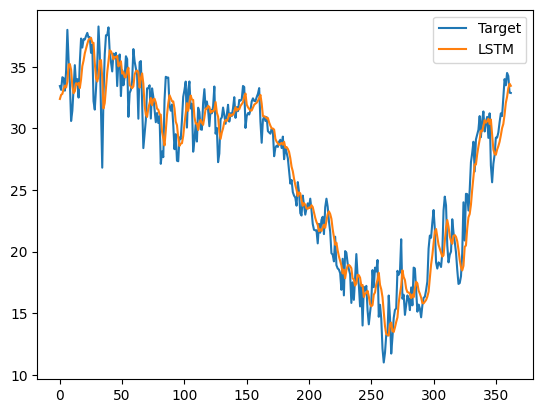

In [ ]:
# @title Predição CNN
pred_cnn = cnn_model.predict(np.expand_dims(X_test, axis=-1))
pred_cnn = scaler.inverse_transform(pred_cnn)

prediction_plot(pred = pred_lstm, y = scaler.inverse_transform(y_test.reshape(-1, 1)), model_name = 'CNN')

In [ ]:
# @title Resultados CNN
result = get_results(scaler.inverse_transform(y_test.reshape(-1, 1)), pred_cnn)
results['cnn'] = result

result

{'mse': 5.62, 'mae': 1.92, 'rmse': 5.62}

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.9 MB/s eta 0:00:00


In [ ]:
# @title ARIMA
from pmdarima import auto_arima

arima_train = df_train.meantemp
arima_test = df_test.meantemp

model = auto_arima(arima_train, seasonal=True, trace=True)
print(model.summary())

forecast = model.predict(n_periods=len(arima_test))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4491.717, Time=1.78 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8078.928, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4558.728, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6852.842, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11018.217, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4507.939, Time=0.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4489.732, Time=1.22 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4523.647, Time=0.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4531.821, Time=0.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4491.714, Time=1.91 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4523.321, Time=0.69 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=4491.456, Time=3.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4492.004, Time=1.07 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 12.949 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1181
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -2239.866
Date:                Fri, 24 Jan 2025   AIC                           4489.732
Time:                        15:15:25   BIC                           4515.102
Sample:                    01-01-2013   HQIC                          4499.296
                         - 03-26-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0506      0.030      1.672      0.094      -0.009

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


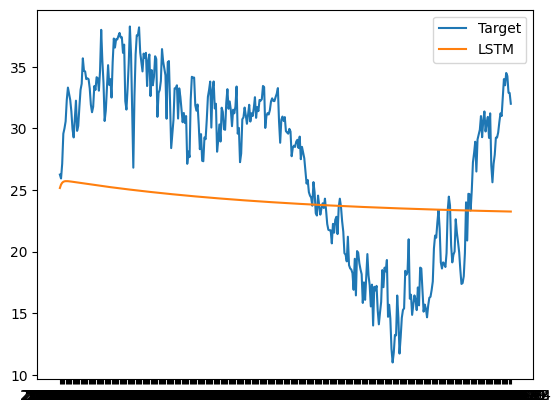

In [ ]:
pred_arima = pd.Series(forecast, index=arima_test.index)
prediction_plot(pred = pred_arima, y = arima_test, model_name = 'ARIMA')

In [ ]:
# @title Resultados ARIMA
result = get_results(arima_test, forecast)
results['arima'] = result

result

{'mse': 49.69, 'mae': 6.36, 'rmse': 49.69}

In [ ]:
# @title Comparação de resultados

round(pd.DataFrame(results), 2)

,lstm,svr,cnn,arima
mse,3.43,0.00,5.62,49.69
mae,1.44,0.04,1.92,6.36
rmse,3.43,0.00,5.62,49.69
